<a href="https://colab.research.google.com/github/sakshi326/insurance/blob/main/insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64


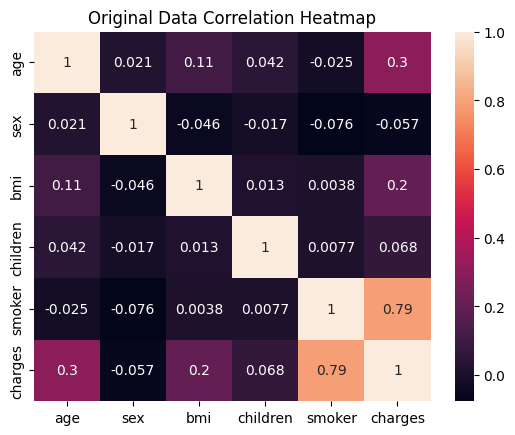

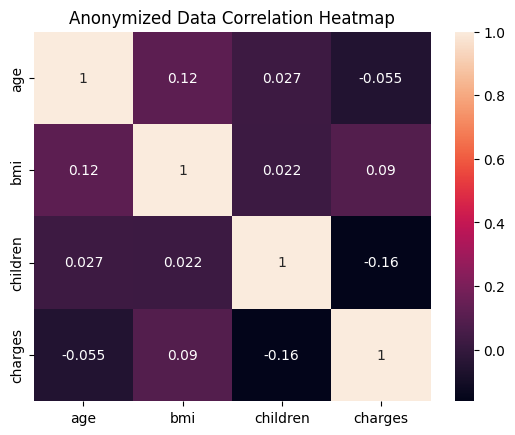

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.patches as patches
import numpy as np

url = '/content/insurance.csv'
df = pd.read_csv(url)
#df

df['sex']= df['sex'].map({'male':0,'female':1})
df['smoker']= df['smoker'].map({'yes':1,'no':0})
df.head()
print(df.children.value_counts())
df.drop(columns=['region'], inplace=True)
# sns.heatmap(df.corr());
#changing the data type of the variables in our dataset to categorical
categorical = set((
  'sex',
  'smoker',
  # 'region',
))
for name in categorical:
  df[name] = df[name].astype('category')
df.dtypes

def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in scale for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if pd.api.types.CategoricalDtype.is_dtype(df[column]):
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

full_spans = get_spans(df, df.index)
full_spans

def split(df, partition, column):
  dfp = df[column][partition]
  if column in categorical:
    values = dfp.unique()
    lv = set(values[:len(values)//2])
    rv = set(values[len(values)//2:])
    return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
  else:
    median = dfp.median()
    dfl = dfp.index[dfp < median]
    dfr = dfp.index[dfp >= median]
    return (dfl, dfr)

def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the is_valid function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

feature_columns = ['age', 'bmi', 'children']
sensitive_column = 'charges'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)
# we get the number of partitions that were created len(finished_partitions)
len(finished_partitions)

def build_indexes(df):
  indexes = {}
  for column in categorical:
    values = sorted(df[column].unique())
    indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
  return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
  if pd.api.types.CategoricalDtype.is_dtype(df[column]):
    sv = df[column][partition].sort_values()
    if len(sv) == 0:
            return None, None
    l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
  else:
    sv = df[column][partition].sort_values()
    next_value = sv[sv.index[-1]]
    larger_values = df[df[column] > next_value][column]
    if len(larger_values) > 0:
      next_value = larger_values.min()
      l = sv[sv.index[0]]
      r = next_value
      l -= offset
      r += offset
      return l, r
  return None, None

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
  rects = []
  for partition in partitions:
    xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
    yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
    if xl is None or xr is None or yl is None or yr is None:
      continue
    rects.append(((xl, yl),(xr, yr)))
  return rects

def get_bounds(df, column, indexes, offset=1.0):
  if column in categorical:
    return 0-offset, len(indexes[column])+offset
  return df[column].min()-offset, df[column].max()+offset
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

def agg_categorical_column(series):
    return [','.join(set(series))]
def agg_numerical_column(series):
    return [series.mean()]
# def agg_numerical_column_min(series):
#     return [series.min()]
# def agg_numerical_column_max(series):
#     return [series.max()]


def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if pd.api.types.is_categorical_dtype(df[column]):
            aggregations[column] = lambda x: ','.join(set(x))
        else:
            aggregations[column] = 'mean'
    aggregations[sensitive_column] = 'count'

    rows = []
    for i, partition in enumerate(partitions):
        if max_partitions is not None and i >= max_partitions:
            break
        grouped_columns = df.loc[partition, feature_columns + [sensitive_column]].agg(aggregations)
        rows.append(grouped_columns.to_dict())

    return pd.DataFrame(rows)

dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

sns.heatmap(df.corr(), annot=True);
plt.title('Original Data Correlation Heatmap')
plt.show()

if not dfn.empty:
    sns.heatmap(dfn.corr(), annot=True);
    plt.title('Anonymized Data Correlation Heatmap')
    plt.show()
else:
    print("DataFrame dfn is empty.")